In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from collections import Counter
import joblib

In [2]:
goodFeat = pd.read_csv("good_website_featues18000.csv")
badFeat = pd.read_csv("bad_website_features15000.csv")

In [3]:
badFeat['TargetScore'] = 0
goodFeat['TargetScore'] = 1

In [42]:
X = pd.concat([badFeat,goodFeat],ignore_index=True)
X = X.sample(frac=1).reset_index(drop = True)

In [5]:
X.describe()

Unnamed: 0     urlLength      urlDepth     domainAge        sslAge  \
count  28605.000000  28605.000000  28605.000000  23624.000000  21831.000000   
mean    7155.626848     40.508338     -0.102255   4768.341729     95.425725   
std     4137.283872     44.897385      1.304793   3637.022098    100.138846   
min        0.000000     15.000000     -1.000000      3.000000      0.000000   
25%     3575.000000     23.000000     -1.000000   1268.000000     23.000000   
50%     7151.000000     27.000000     -1.000000   4226.000000     44.000000   
75%    10726.000000     45.000000      0.000000   8017.500000    159.000000   
max    14675.000000   4217.000000     16.000000  14425.000000    396.000000   

           PageRank      @present     //present   TargetScore  
count  1.770500e+04  28605.000000  28605.000000  28605.000000  
mean   2.083663e+07      0.005943      1.001503      0.513057  
std    4.688827e+07      0.082140      0.054492      0.499838  
min    1.000000e+00      0.000000      1.000000      0.000000  
25%    1.223100e+04      0.000000      1.000000      0.000000  
50%    3.055660e+05      0.000000      1.000000      1.000000  
75%    2.609200e+07      0.000000      1.000000      1.000000  
max    3.714833e+08      4.000000      4.000000      1.000000

In [6]:
X.isnull().sum()

Unnamed: 0             0
urlLength              0
urlDepth               0
isShort            27272
hasIP                  0
hasEmail               0
protocol               0
misleadingChars        0
domain                 0
domainAge           4981
registrar           5697
sslAge              6774
PageRank           10900
@present               0
//present              0
URL                    0
TargetScore            0
dtype: int64

In [7]:
X.dtypes

Unnamed: 0           int64
urlLength            int64
urlDepth             int64
isShort             object
hasIP                 bool
hasEmail              bool
protocol            object
misleadingChars       bool
domain              object
domainAge          float64
registrar           object
sslAge             float64
PageRank           float64
@present             int64
//present            int64
URL                 object
TargetScore          int64
dtype: object

In [8]:
'''
Filling the isShort null values with false as the dataset only contained true values
Pagerank is set to a very large number for websites that are unranked ( Not in the top 1 million by traffic)
Registrar set to empty string to avoid errors
'''
X['isShort'].fillna(False,inplace=True)
X['PageRank'].fillna(10000000,inplace = True)
X['registrar'].fillna("",inplace= True)

In [9]:
# FIlling the null values in sslAge and domainAge with the mean
sslMean = X['sslAge'].mean()
domainAgeMean = X['domainAge'].mean()
X.sslAge.fillna(sslMean,inplace= True)
X.domainAge.fillna(domainAgeMean,inplace= True)

In [10]:
y = X['TargetScore']
X.drop(['Unnamed: 0','URL','TargetScore'],axis= 1 , inplace=True)

In [11]:
X['domain'] = X.domain.apply(lambda url : url.split('.')[-1] if len(url.split('.')) > 2 else 'None')

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [13]:
X_test.to_csv("RawTestData.csv")
y_test.to_csv("RawTestTarget.csv")

In [14]:
encodedColumns = ['registrar','domain','protocol']      
ord = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
X_train[encodedColumns] = ord.fit_transform(X_train[encodedColumns])
X_test[encodedColumns] = ord.transform(X_test[encodedColumns])

In [15]:
joblib.dump(ord,'OrdinalEncoder.pkl')

['OrdinalEncoder.pkl']

In [16]:
print(sslMean,domainAgeMean)

95.42572488662911 4768.3417287504235


<Axes: >

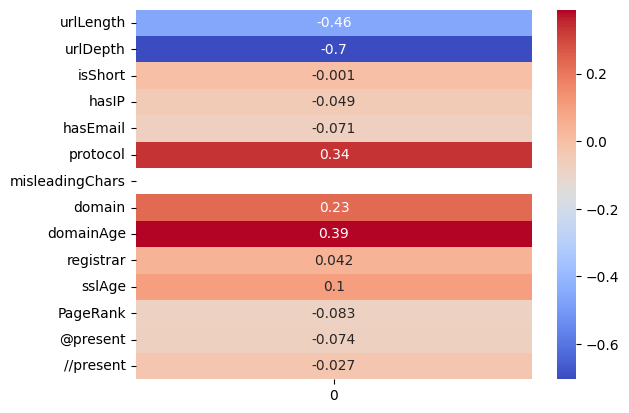

In [17]:
corrTarget = X_train.corrwith(y_train)
sns.heatmap(corrTarget.to_frame(),annot= True,cmap= 'coolwarm')

C:\Users\abhir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\abhir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


<Axes: >

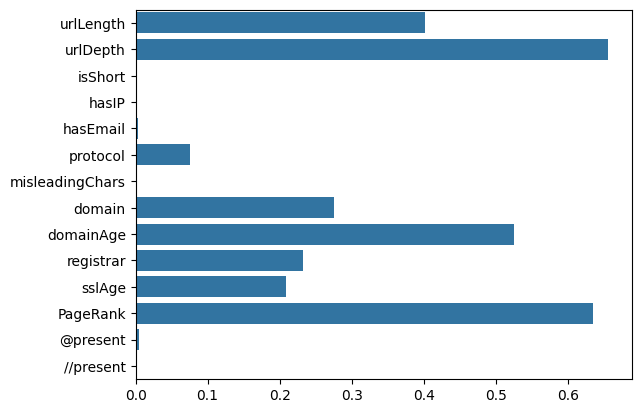

In [18]:
mutualInfo = {}
for col in X_train.columns:
    mutualInfo[col] = (mutual_info_score(X_train[col],y_train))
sns.barplot(x = mutualInfo.values(), y = mutualInfo.keys())

In [19]:
#Discarding the columns that have very low MI and corr 
discardedCols = ['isShort','hasIP','hasEmail','misleadingChars','//present','@present']
X_train.drop(discardedCols,axis = 1,inplace= True)
X_test.drop(discardedCols,axis = 1,inplace = True)

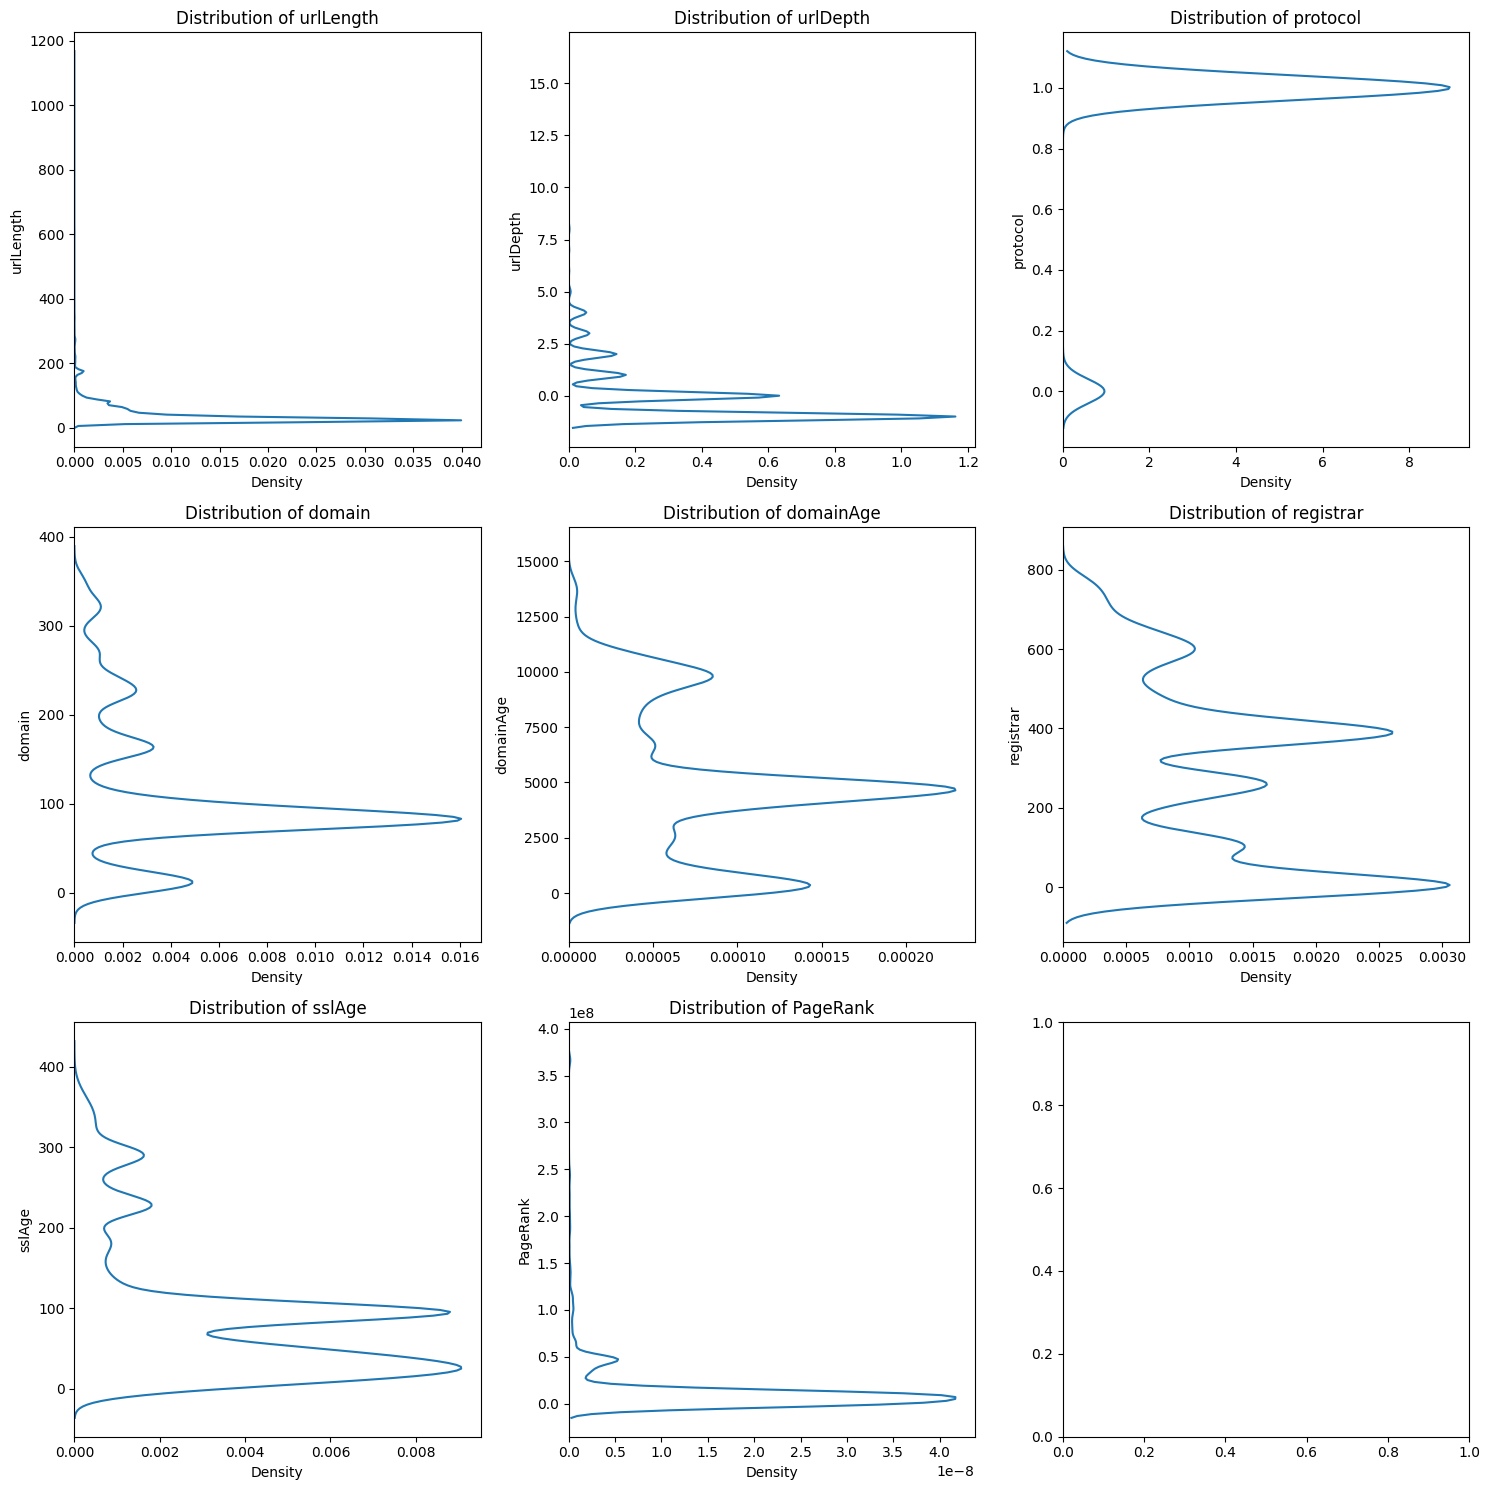

In [20]:
# Plotting in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# List of feature names
features = X_train.columns

# Loop to create a subplot for each feature
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.kdeplot(y=X_train[feature], ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

# Adjust layout
plt.tight_layout()
plt.show()

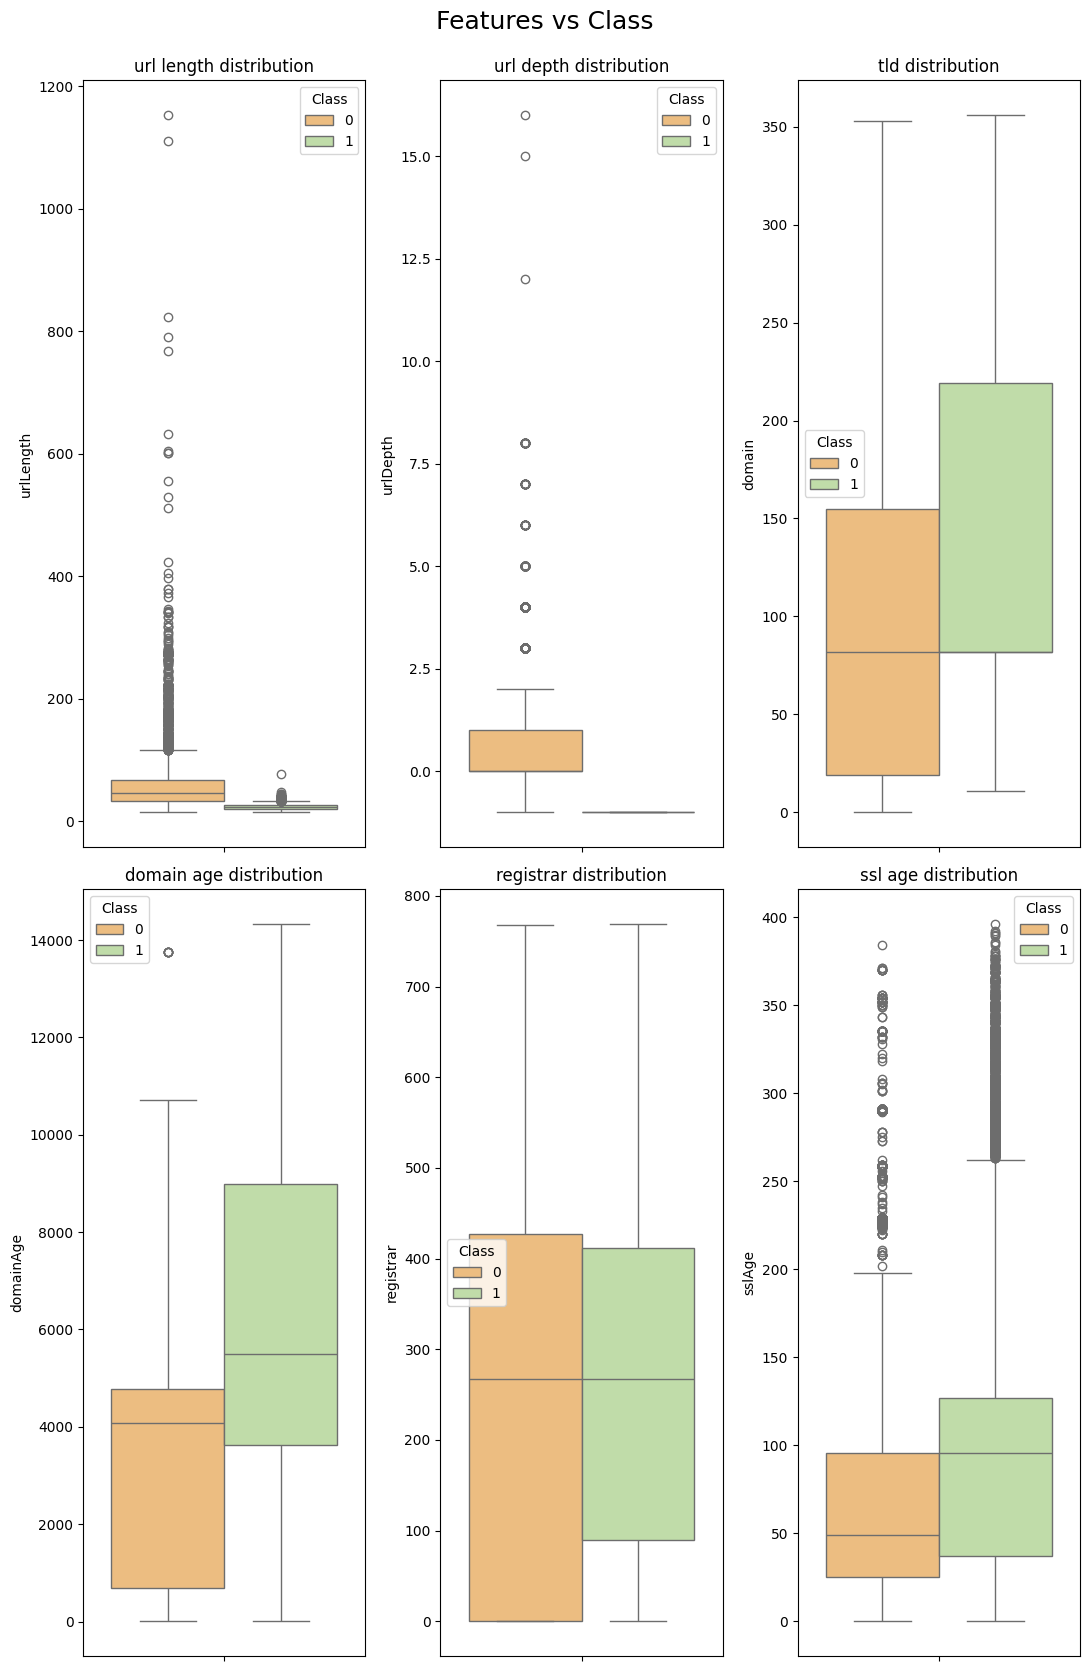

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 17))
fig.suptitle('Features vs Class\n', size=18)

sns.boxplot(ax=axes[0, 0], data=X_train.assign(Class=y), hue='Class', y='urlLength', palette='Spectral')
axes[0, 0].set_title("url length distribution")

sns.boxplot(ax=axes[0, 1], data=X_train.assign(Class=y), hue='Class', y='urlDepth', palette='Spectral')
axes[0, 1].set_title("url depth distribution")

sns.boxplot(ax=axes[0, 2], data=X_train.assign(Class=y), hue='Class', y='domain', palette='Spectral')
axes[0, 2].set_title("tld distribution")

sns.boxplot(ax=axes[1, 0], data=X_train.assign(Class=y), hue='Class', y='domainAge', palette='Spectral')
axes[1, 0].set_title("domain age distribution")

sns.boxplot(ax=axes[1, 1], data=X_train.assign(Class=y), hue='Class', y='registrar', palette='Spectral')
axes[1, 1].set_title("registrar distribution")

sns.boxplot(ax=axes[1, 2], data=X_train.assign(Class=y), hue='Class', y='sslAge', palette='Spectral')
axes[1, 2].set_title("ssl age distribution")

plt.tight_layout()
plt.show()


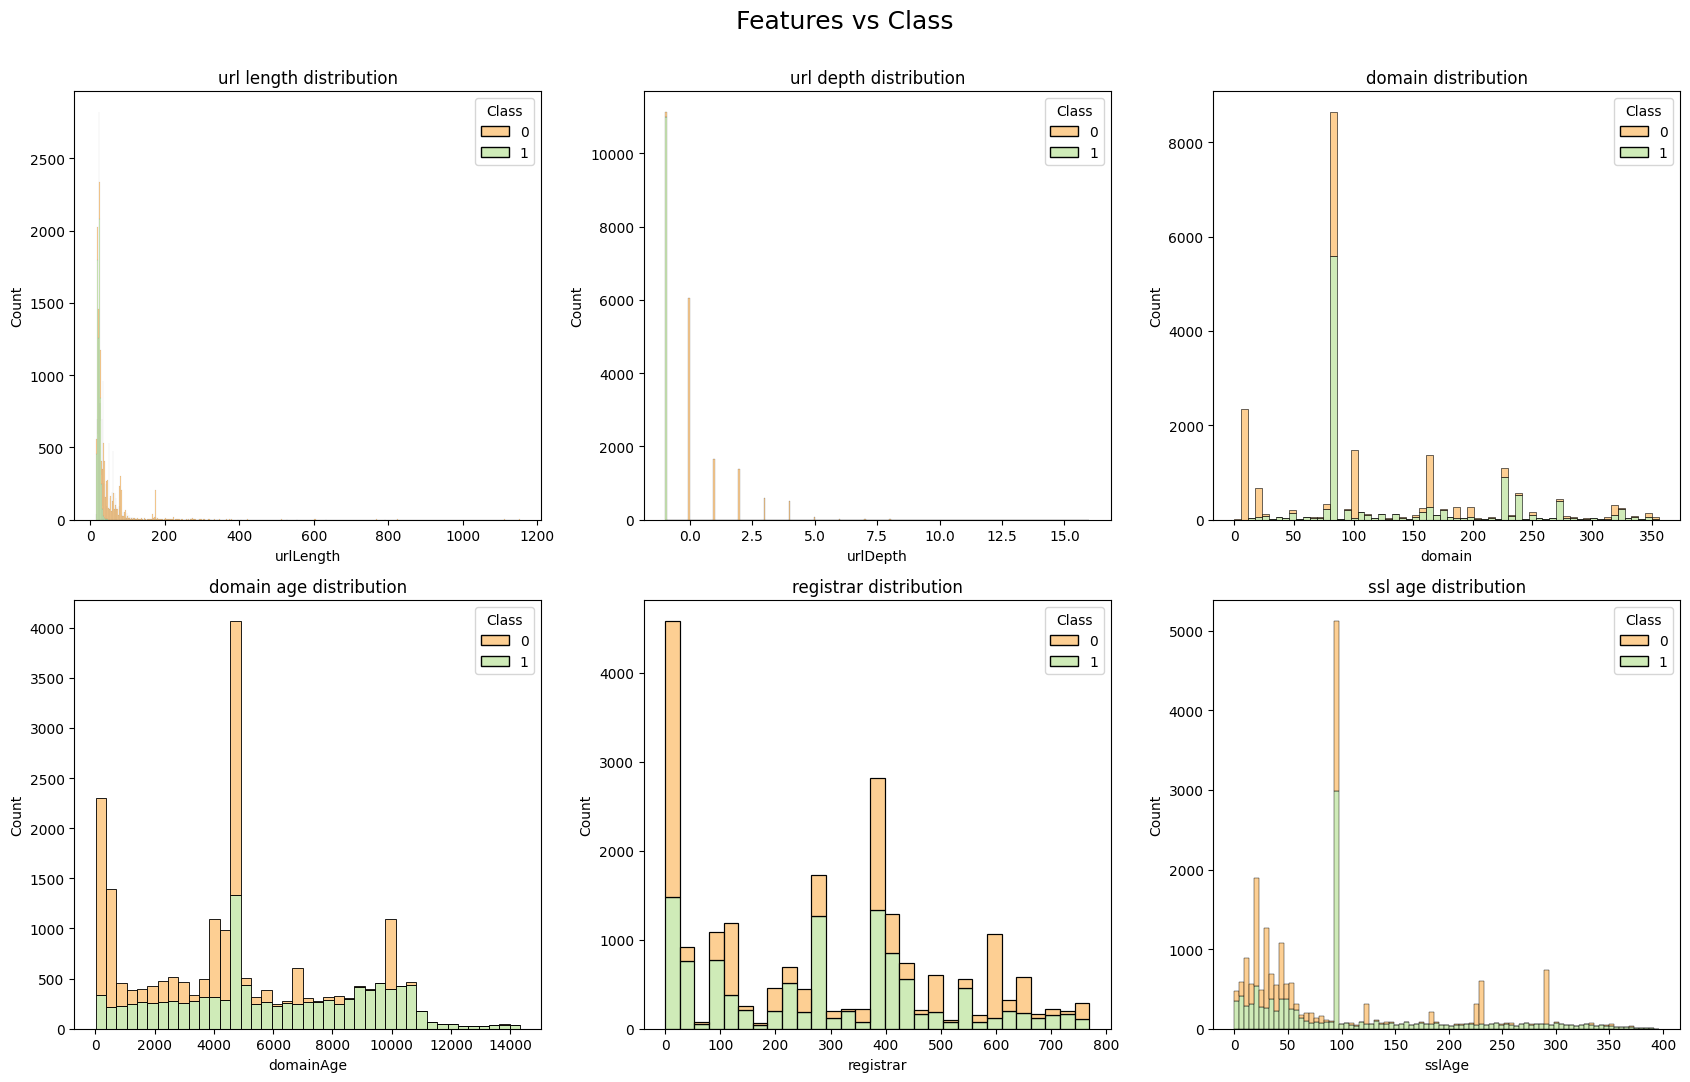

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 11))
fig.suptitle('Features vs Class\n', size=18)

sns.histplot(data=X_train.assign(Class=y), x='urlLength', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 0])
axes[0, 0].set_title("url length distribution")

sns.histplot(data=X_train.assign(Class=y), x='urlDepth', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 1])
axes[0, 1].set_title("url depth distribution")

sns.histplot(data=X_train.assign(Class=y), x='domain', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 2])
axes[0, 2].set_title("domain distribution")

sns.histplot(data=X_train.assign(Class=y), x='domainAge', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 0])
axes[1, 0].set_title("domain age distribution")

sns.histplot(data=X_train.assign(Class=y), x='registrar', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 1])
axes[1, 1].set_title("registrar distribution")

sns.histplot(data=X_train.assign(Class=y), x='sslAge', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 2])
axes[1, 2].set_title("ssl age distribution")

plt.tight_layout()
plt.show()

In [23]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [24]:
X_train_iqr = X_train.copy()
X_train_iqr['Class'] = y
Outliers_IQR = IQR_method(X_train_iqr,1,X_train.columns)

Total number of outliers is: 3363


In [25]:
X_train_iqr = X_train_iqr.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

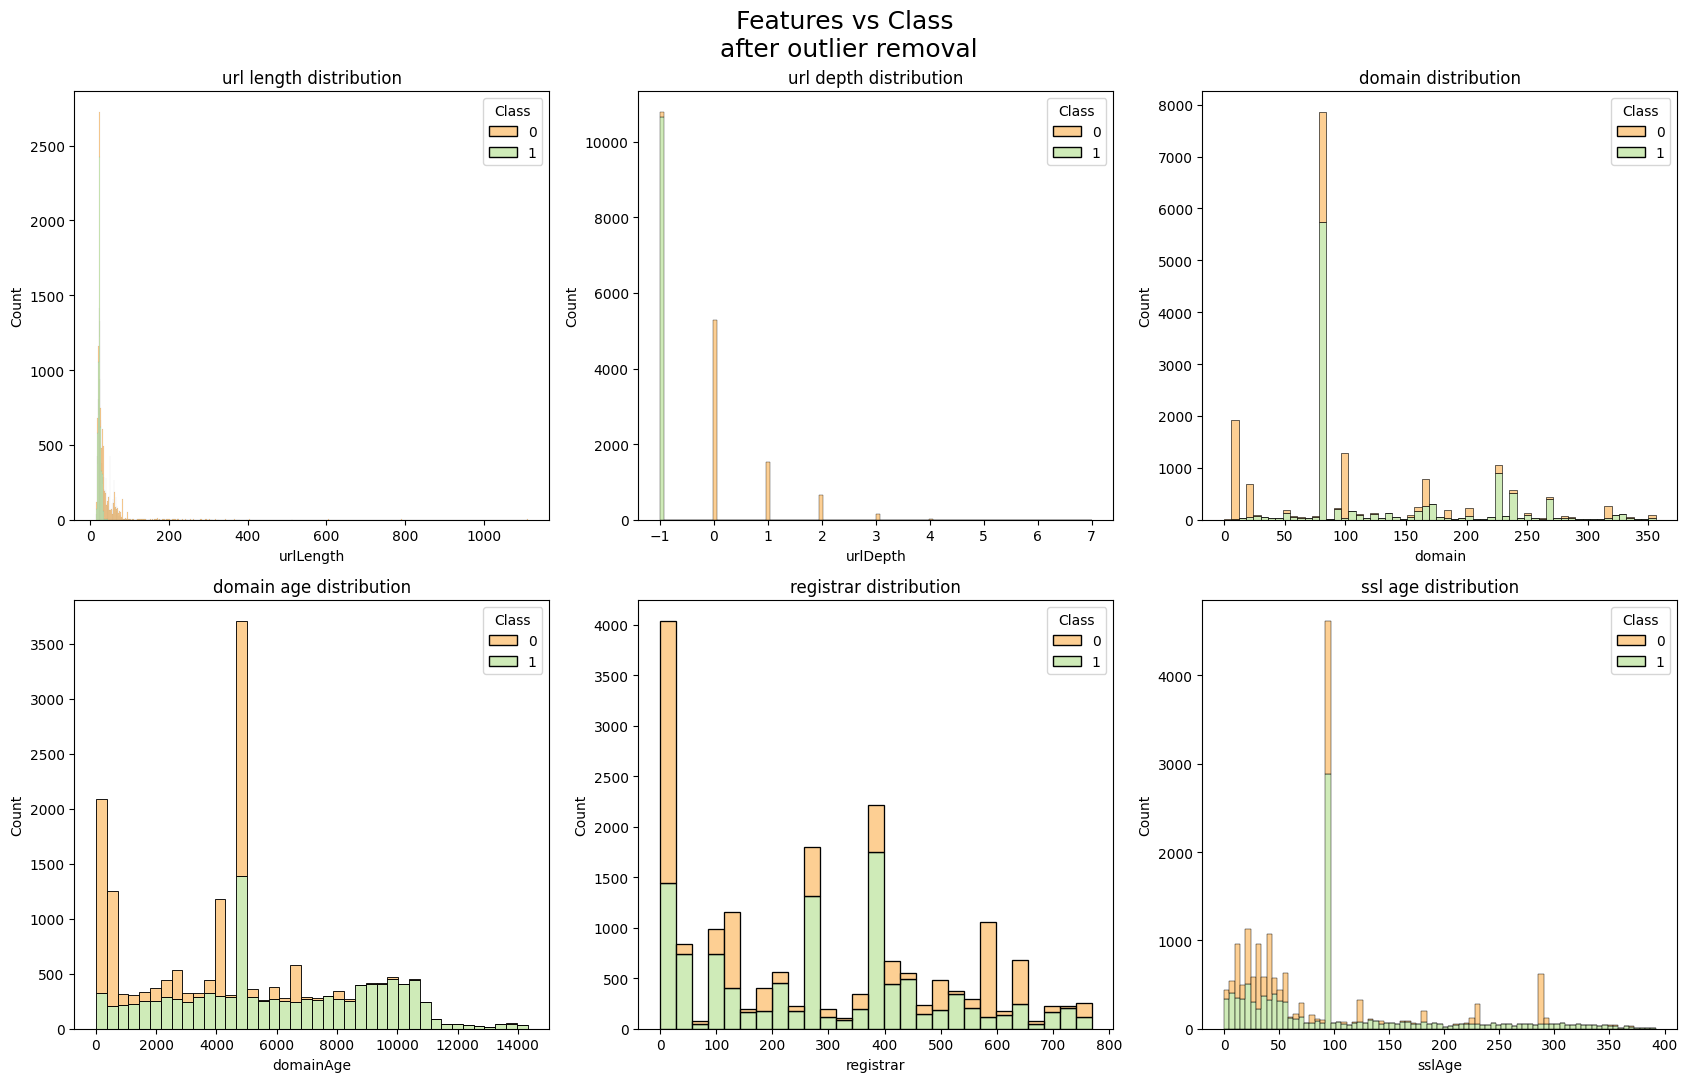

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 11))
fig.suptitle('Features vs Class\n after outlier removal', size=18)

sns.histplot(data=X_train_iqr, x='urlLength', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 0])
axes[0, 0].set_title("url length distribution")

sns.histplot(data=X_train_iqr, x='urlDepth', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 1])
axes[0, 1].set_title("url depth distribution")

sns.histplot(data=X_train_iqr, x='domain', hue='Class', multiple='stack', palette='Spectral', ax=axes[0, 2])
axes[0, 2].set_title("domain distribution")

sns.histplot(data=X_train_iqr, x='domainAge', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 0])
axes[1, 0].set_title("domain age distribution")

sns.histplot(data=X_train_iqr, x='registrar', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 1])
axes[1, 1].set_title("registrar distribution")

sns.histplot(data=X_train_iqr, x='sslAge', hue='Class', multiple='stack', palette='Spectral', ax=axes[1, 2])
axes[1, 2].set_title("ssl age distribution")

plt.tight_layout()
plt.show()

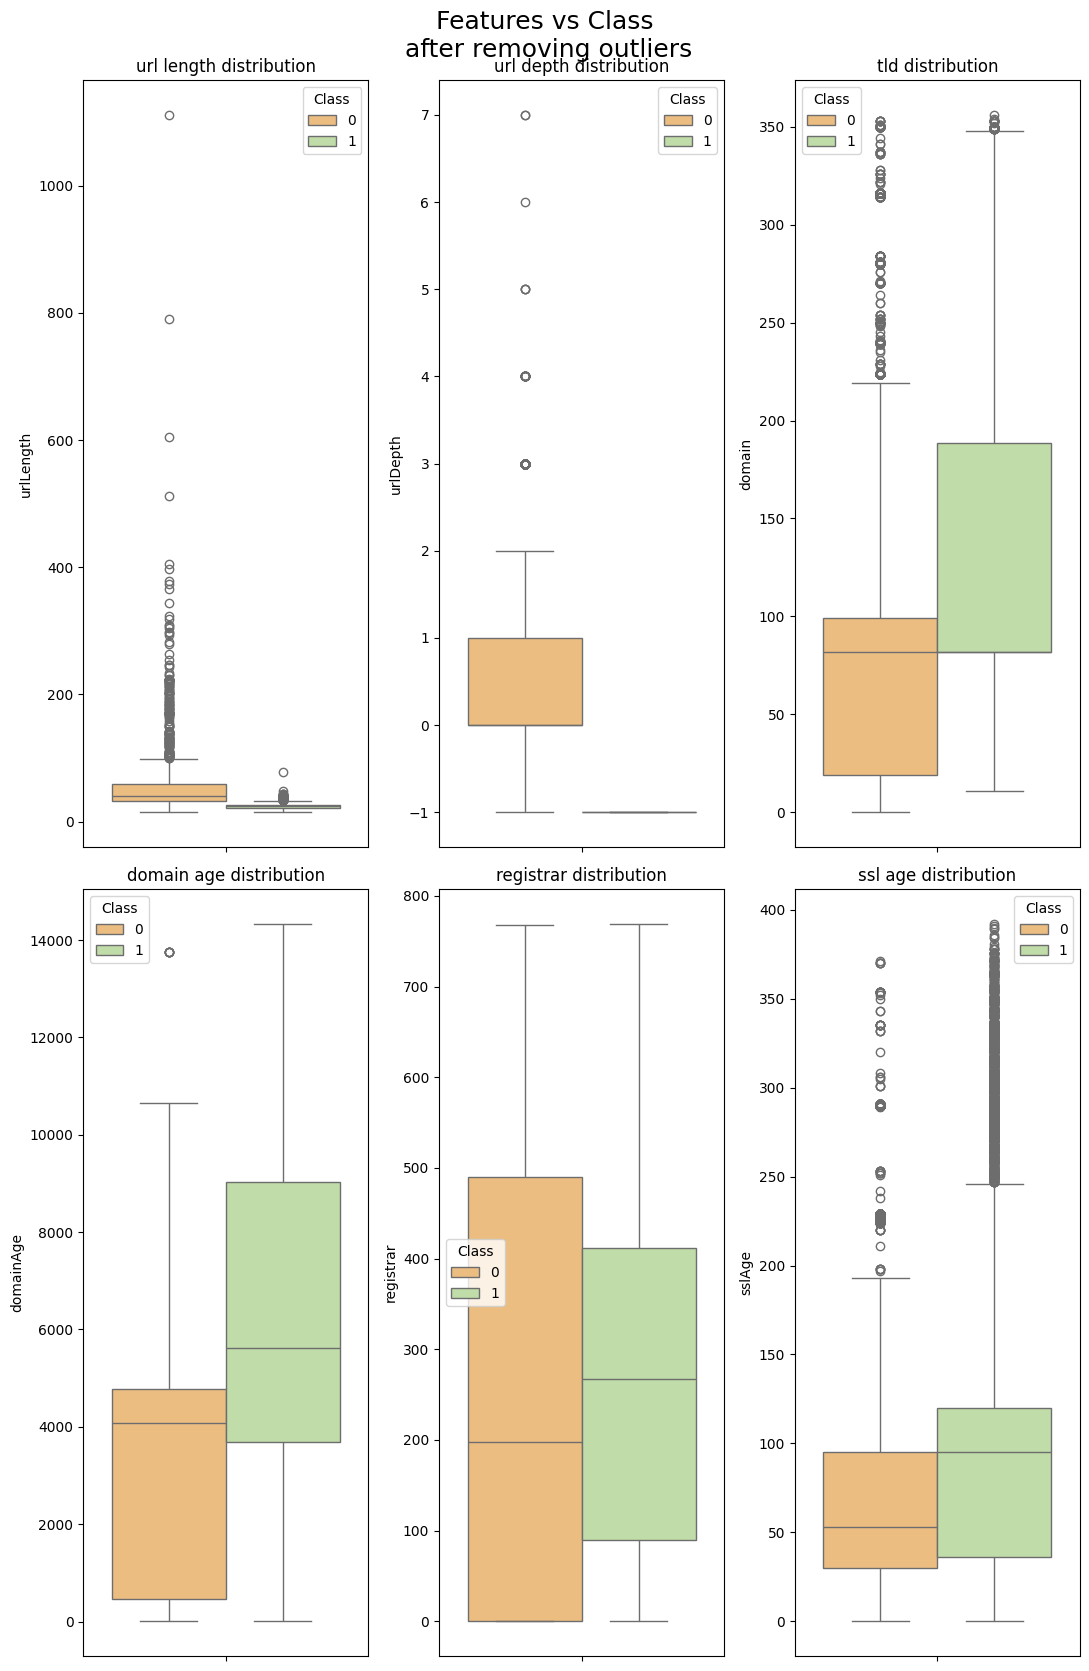

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 17))
fig.suptitle('Features vs Class\n after removing outliers', size=18)

sns.boxplot(ax=axes[0, 0], data=X_train_iqr, hue='Class', y='urlLength', palette='Spectral')
axes[0, 0].set_title("url length distribution")

sns.boxplot(ax=axes[0, 1], data=X_train_iqr, hue='Class', y='urlDepth', palette='Spectral')
axes[0, 1].set_title("url depth distribution")

sns.boxplot(ax=axes[0, 2], data=X_train_iqr, hue='Class', y='domain', palette='Spectral')
axes[0, 2].set_title("tld distribution")

sns.boxplot(ax=axes[1, 0], data=X_train_iqr, hue='Class', y='domainAge', palette='Spectral')
axes[1, 0].set_title("domain age distribution")

sns.boxplot(ax=axes[1, 1], data=X_train_iqr, hue='Class', y='registrar', palette='Spectral')
axes[1, 1].set_title("registrar distribution")

sns.boxplot(ax=axes[1, 2], data=X_train_iqr, hue='Class', y='sslAge', palette='Spectral')
axes[1, 2].set_title("ssl age distribution")

plt.tight_layout()
plt.show()


In [28]:
# Outlier detection using IQR
from sklearn.ensemble import IsolationForest

X_train_IF = X_train.copy()
model = IsolationForest() 
model.fit(X_train_IF) 

IsolationForest()

In [29]:
scores=model.decision_function(X_train_IF)
anomaly=model.predict(X_train_IF)

X_train_IF['scores']=scores
X_train_IF['anomaly']=anomaly

anomaly = X_train_IF.loc[X_train_IF['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 3659


In [30]:
df_out5 = X_train_IF.drop(anomaly_index, axis = 0).reset_index(drop=True)

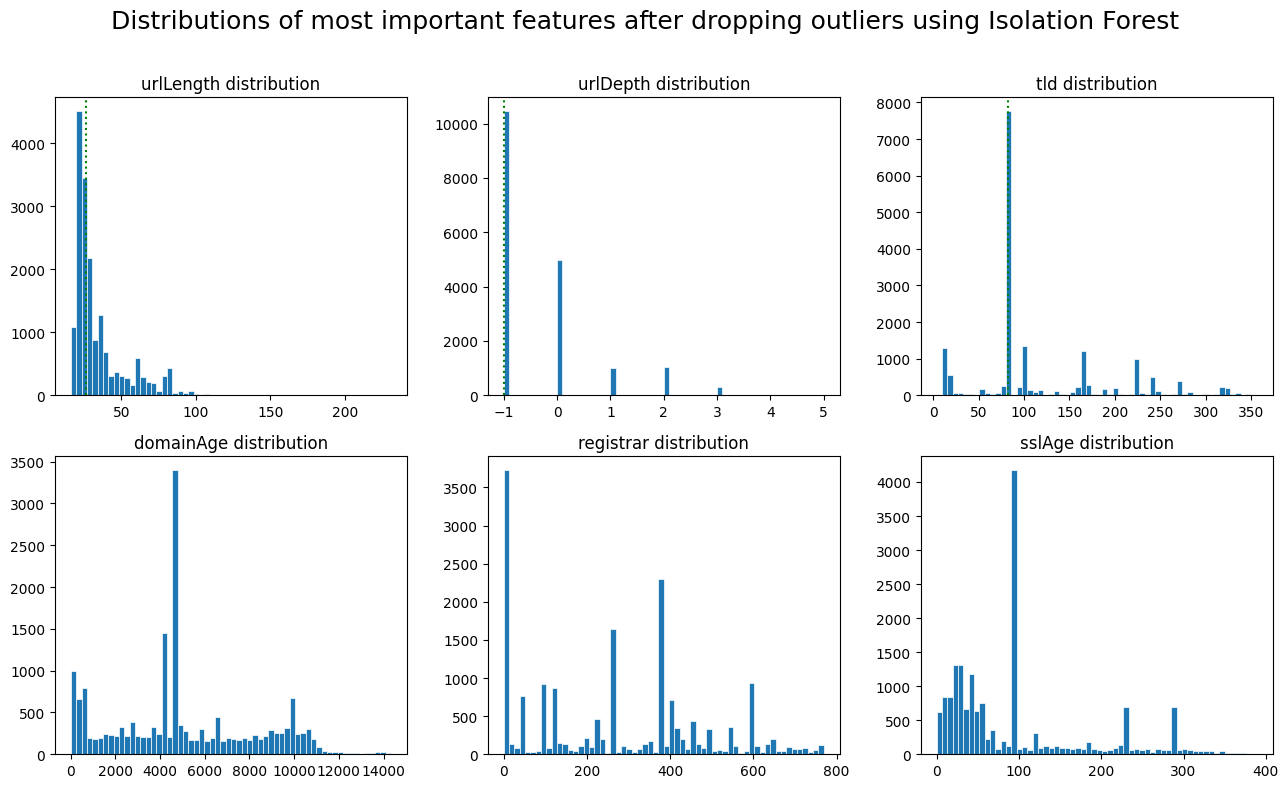

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using Isolation Forest\n', size = 18)

axes[0,0].hist(df_out5['urlLength'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out5['urlLength']), ls=':', c='g', label="Median")
axes[0,0].set_title("urlLength distribution");

axes[0,1].hist(df_out5['urlDepth'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out5['urlDepth']), ls=':', c='g', label="Median")
axes[0,1].set_title("urlDepth distribution");

axes[0,2].hist(df_out5['domain'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out5['domain']), ls=':', c='g', label="Median")
axes[0,2].set_title("tld distribution");

axes[1,0].hist(df_out5['domainAge'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("domainAge distribution");

axes[1,1].hist(df_out5['registrar'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("registrar distribution");

axes[1,2].hist(df_out5['sslAge'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("sslAge distribution");

plt.tight_layout()

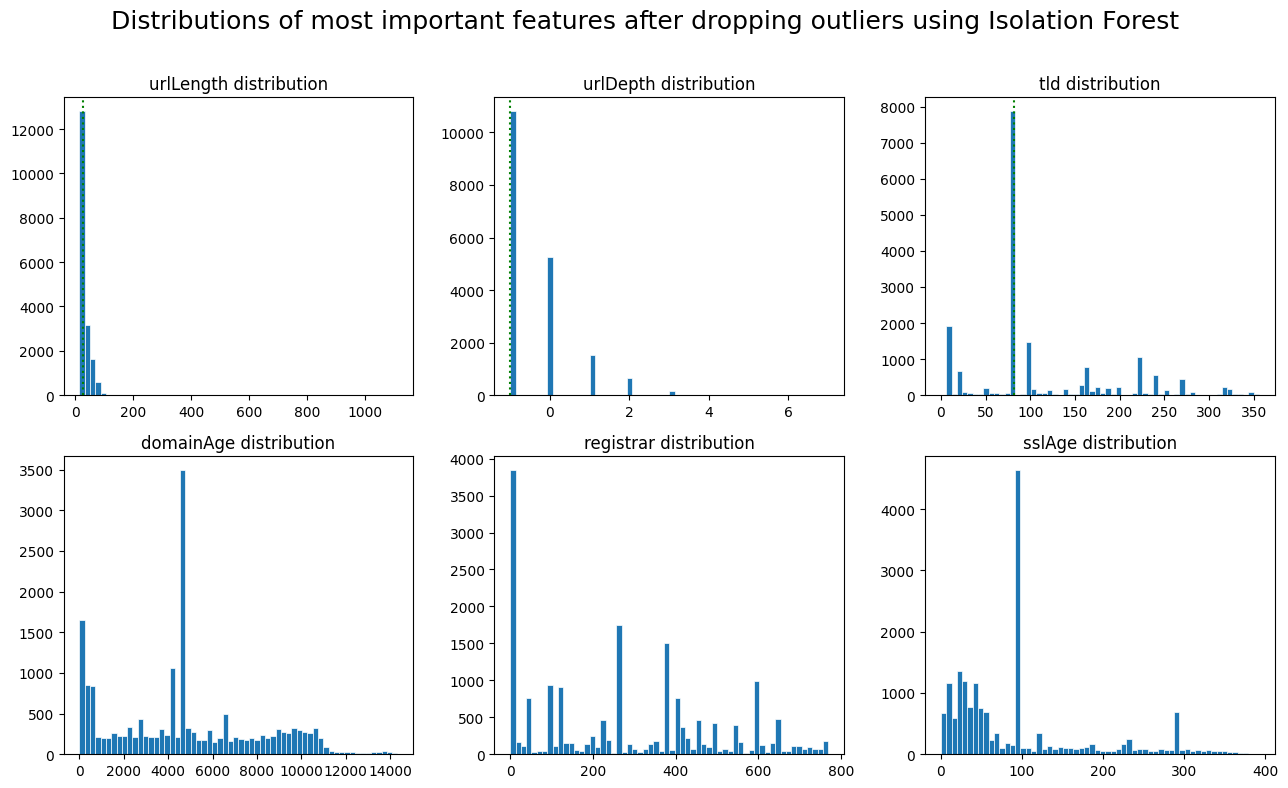

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using Isolation Forest\n', size = 18)

axes[0,0].hist(X_train_iqr['urlLength'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(X_train_iqr['urlLength']), ls=':', c='g', label="Median")
axes[0,0].set_title("urlLength distribution");

axes[0,1].hist(X_train_iqr['urlDepth'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(X_train_iqr['urlDepth']), ls=':', c='g', label="Median")
axes[0,1].set_title("urlDepth distribution");

axes[0,2].hist(X_train_iqr['domain'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(X_train_iqr['domain']), ls=':', c='g', label="Median")
axes[0,2].set_title("tld distribution");

axes[1,0].hist(X_train_iqr['domainAge'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("domainAge distribution");

axes[1,1].hist(X_train_iqr['registrar'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("registrar distribution");

axes[1,2].hist(X_train_iqr['sslAge'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("sslAge distribution");

plt.tight_layout()

In [33]:
#Isolation forest is producing better results
X_train_IF.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

In [34]:
X.head()

urlLength  urlDepth  isShort  hasIP  hasEmail protocol  misleadingChars  \
0         35         0    False  False     False    https            False   
1         86         0    False  False     False     http            False   
2         24        -1    False  False     False    https            False   
3         68         0    False  False     False    https            False   
4         21        -1    False  False     False    https            False   

  domain  domainAge                                    registrar      sslAge  \
0     io     4086.0                            MarkMonitor, Inc.  229.000000   
1     me     2839.0                                    eNom, LLC   20.000000   
2    art      146.0                                NAMECHEAP INC   47.000000   
3    com      865.0                             GoDaddy.com, LLC  109.000000   
4    net     4712.0  Alibaba Cloud Computing (Beijing) Co., Ltd.   95.425725   

     PageRank  @present  //present  
0  37353298.0         0          1  
1  10000000.0         0          1  
2  10000000.0         0          1  
3  10000000.0         0          1  
4  47581333.0         0          1

In [35]:
discardedCols = ['isShort','hasIP','hasEmail','misleadingChars','//present','@present']
X.drop(discardedCols,axis=1,inplace=True)
X.to_csv("RawData.csv")